In [1]:
from sklearn.model_selection import train_test_split as TTS, cross_validate as cv 
from sklearn.preprocessing import MinMaxScaler as MMS, StandardScaler as SScaler
from sklearn.metrics import mean_squared_error as MSE, r2_score as r2
from matplotlib import pyplot as plt
import time, scipy, numpy as np, math, pickle, random, warnings, pandas as pd, csv, hyperas
from sklearn.pipeline import Pipeline
from hyperopt import STATUS_OK, tpe, Trials, hp, fmin
from functools import partial
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.python.keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.python.framework import ops
import flair
from joblib import dump, load
import numpy as np
#


    #This notebook adds the data for BO recommended io value predictions and subsequently generates graphs


#

Using TensorFlow backend.


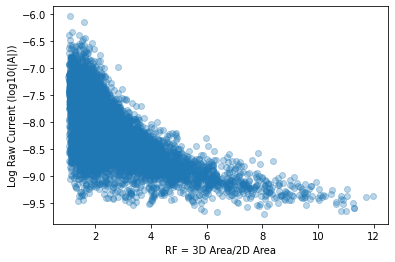

,CER,HER,E,hco3,ord,p,l,d,dif,Cur_Raw,RF,Cur_RF,Log_Cur_Raw,HER_Raw,Log_HER_Raw
0,-17.941381,-522.282298,-1.04,1.80,0.489544,27.7,26.3,0.52,171,-4.145082e-07,1.055995,-3.925286e-07,-6.382467,-4.007420e-07,-6.397135
1,-12.364044,-406.508341,-1.01,1.72,0.281256,22.0,18.0,2.20,171,-2.027342e-07,1.257039,-1.612792e-07,-6.693073,-1.967500e-07,-6.706085
2,-9.781413,-361.163480,-1.01,1.94,0.389975,26.2,15.0,7.50,171,-2.546314e-07,1.514872,-1.680877e-07,-6.594088,-2.479171e-07,-6.605694
3,-8.767042,-381.446007,-1.00,1.87,0.181063,24.0,34.0,0.70,171,-2.247627e-07,1.129809,-1.989387e-07,-6.648276,-2.197129e-07,-6.658144
4,-8.445355,-533.502570,-1.05,1.83,0.530908,20.0,19.8,1.53,171,-2.167792e-07,1.237928,-1.751145e-07,-6.663982,-2.134010e-07,-6.670803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9572,-18.297250,-0.565387,-0.61,0.66,0.367542,25.5,30.3,1.36,89,-1.226543e-08,1.199091,-1.022894e-08,-7.911317,-3.676428e-10,-9.434574
9573,-13.178093,-0.327476,-0.62,0.06,0.821262,25.7,39.8,5.44,136,-8.920293e-09,2.029829,-4.394603e-09,-8.049621,-2.162944e-10,-9.664955
9574,-49.770066,-1.594073,-0.70,1.65,0.360273,28.4,43.6,1.24,64,-4.142826e-08,1.210582,-3.422177e-08,-7.382703,-1.285715e-09,-8.890855
9575,-16.295122,-0.553190,-0.61,0.63,0.540049,22.3,38.7,7.43,49,-8.378497e-09,2.816517,-2.974772e-09,-8.076834,-2.750958e-10,-9.560516


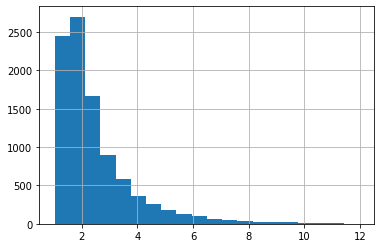

In [33]:
f = pd.read_csv('./Wire/Wire_OG_MorphRange.csv')
f['Cur_Raw'] = (f['CER'] + f['HER'])*(f['p']*10**-6*f['p']*10**-6)
f['RF'] = ((3.14159*f['l']*f['d'])+(f['p']*f['p']))/(f['p']*f['p'])
f['Cur_RF'] = f['Cur_Raw']/f['RF']
f['Log_Cur_Raw'] = f.apply(lambda x: math.log10(-1*x.Cur_Raw), axis=1)
f['HER_Raw'] = f['HER']*(f['p']*10**-6*f['p']*10**-6)
f['Log_HER_Raw'] = f.apply(lambda x: math.log10(-1*x.HER_Raw), axis=1)
plt.scatter(f['RF'], f['Log_Cur_Raw'], alpha=0.3)
plt.ylabel('Log Raw Current (log10(|A|))')
plt.xlabel('RF = 3D Area/2D Area')
plt.savefig('./Wire/RF_Analysis_OG_MorphRange')
plt.show()
plt.clf()
f['RF'].hist(bins=20)
f

0     23.058573
1     20.454079
2     18.281011
3     97.160171
4     64.298799
        ...    
85    14.985532
86    52.120445
87    32.535856
88    18.226102
89    43.715180
Name: Cur, Length: 90, dtype: float64
      E  HCO3    Order   P   L    D  dif        FE       Cur        RF  \
0  -0.6   0.1  0.26944  17  20  3.0   20  0.986055  1.362832  1.651903   
1  -0.6   0.1  0.26944  17  35  3.0   20  0.980734  1.310780  2.140830   
2  -0.6   0.1  0.26944  17  50  3.0   20  0.979050  1.262000  2.629758   
9  -0.6   0.1  0.26944  46  20  6.0   20  0.986090  1.312611  1.178072   
10 -0.6   0.1  0.26944  46  35  6.0   20  0.980684  1.289327  1.311626   
11 -0.6   0.1  0.26944  46  50  6.0   20  0.977787  1.270613  1.445180   

          Cur_RF  
0    4034.091067  
1    2761.184957  
2    2009.010915  
9   36893.956571  
10  31407.465211  
11  27302.798151  
Empty DataFrame
Columns: [E, HCO3, Order, P, L, D, dif, FE, Cur, RF, Cur_RF]
Index: []
       E  HCO3    Order   P   L    D  dif      

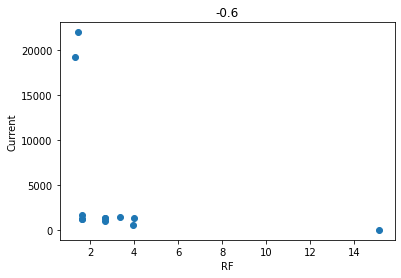

      E  HCO3    Order   P    L    D  dif        FE       Cur         RF  \
58 -0.7   0.1  0.38026  10   10  2.0   70  0.972383  1.717008   1.628000   
59 -0.7   0.1  0.38026  12   15  2.0   70  0.976107  1.734208   1.654167   
60 -0.7   0.1  0.38026  15   30  4.0   70  0.952170  1.500344   2.674667   
61 -0.7   0.1  0.38026  15   70  3.0   70  0.893996  1.141296   3.930667   
66 -0.7   0.1  0.38026  25  100  6.0   70  0.879374  0.926678   4.014400   
67 -0.7   0.1  0.38026   2   20  0.9   70  0.890952  1.320183  15.130000   
68 -0.7   0.1  0.38026  15   30  4.0   70  0.952170  1.500344   2.674667   
69 -0.7   0.1  0.38026  40   40  4.0   70  0.972303  1.720692   1.314000   
86 -0.7   0.1  0.38026  10   10  2.0   70  0.972383  1.717008   1.628000   
87 -0.7   0.1  0.38026  13   30  3.0   70  0.947932  1.512362   2.672189   
88 -0.7   0.1  0.38026  20   50  6.0   70  0.937555  1.260694   3.355000   
89 -0.7   0.1  0.38026  46   50  6.0   70  0.969563  1.640632   1.445180   

          C

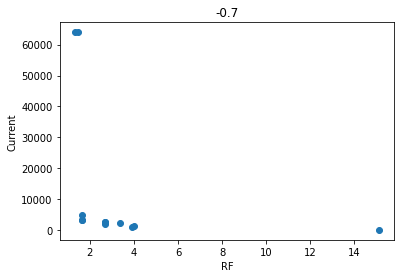

Empty DataFrame
Columns: [E, HCO3, Order, P, L, D, dif, FE, Cur, RF, Cur_RF]
Index: []
      E  HCO3    Order   P    L    D  dif        FE       Cur         RF  \
62 -0.8   0.1  0.38026  10   10  2.0   70  0.895056  1.757544   1.628000   
63 -0.8   0.1  0.38026  12   15  2.0   70  0.891374  1.772869   1.654167   
64 -0.8   0.1  0.38026  15   30  4.0   70  0.663067  1.444240   2.674667   
65 -0.8   0.1  0.38026  15   70  3.0   70  0.208988  0.994588   3.930667   
74 -0.8   0.1  0.38026  25  100  6.0   70  0.157828  0.852362   4.014400   
75 -0.8   0.1  0.38026   2   20  0.9   70  0.581248  1.213534  15.130000   
76 -0.8   0.1  0.38026  15   30  4.0   70  0.663067  1.444240   2.674667   
77 -0.8   0.1  0.38026  40   40  4.0   70  0.843325  1.802859   1.314000   
78 -0.8   0.1  0.38026  10   10  2.0   70  0.895056  1.757544   1.628000   
79 -0.8   0.1  0.38026  13   30  3.0   70  0.672467  1.466195   2.672189   
80 -0.8   0.1  0.38026  20   50  6.0   70  0.436014  1.143999   3.355000   
8

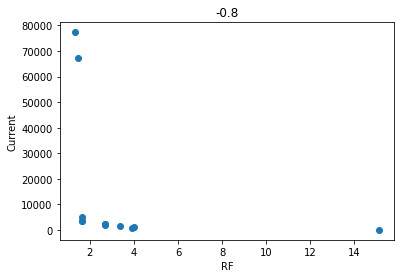

Empty DataFrame
Columns: [E, HCO3, Order, P, L, D, dif, FE, Cur, RF, Cur_RF]
Index: []
      E  HCO3    Order   P   L    D  dif        FE       Cur        RF  \
36 -0.6   0.1  0.26944  17  20  3.0  170  0.960284  1.100606  1.651903   
37 -0.6   0.1  0.26944  17  35  3.0  170  0.952583  1.033747  2.140830   
38 -0.6   0.1  0.26944  17  50  3.0  170  0.944039  0.960228  2.629758   
45 -0.6   0.1  0.26944  46  20  6.0  170  0.962655  1.095115  1.178072   
46 -0.6   0.1  0.26944  46  35  6.0  170  0.950486  1.078874  1.311626   
47 -0.6   0.1  0.26944  46  50  6.0  170  0.943835  1.055817  1.445180   

          Cur_RF  
36   2205.562427  
37   1459.024708  
38   1002.789737  
45  22359.326508  
46  19345.500635  
47  16649.883969  
Empty DataFrame
Columns: [E, HCO3, Order, P, L, D, dif, FE, Cur, RF, Cur_RF]
Index: []
       E  HCO3    Order   P   L    D  dif        FE       Cur        RF  \
39 -0.75   0.1  0.27621  17  20  3.0  170  0.888156  1.469677  1.651903   
40 -0.75   0.1  0.27621 

<Figure size 432x288 with 0 Axes>

In [40]:
#indices
f = pd.read_csv('Yi_Morphs.csv')
f['RF'] = (f['P']*f['P']+6.28*(f['D']/2)*f['L'])/(f['P']*f['P'])
f['Cur_RF'] = ((10**f['Cur'])*f['P']*f['P'])/f['RF']
print(10**f['Cur'])
difs = [20, 50, 70, 170]
r = [-0.6, -0.7, -0.8]
pots = [-0.60, -0.7, -0.75, -0.8, -0.87]
for dif in difs:
    for pot in pots:
        t = f[(f['dif'] == dif) & (f['E'] == pot)]
        print(t)
        if (dif == 70 and pot in r): 
            t.reset_index(drop=True, inplace=True)
            plt.scatter(t['RF'], t['Cur_RF'])
            plt.xlabel('RF')
            plt.ylabel('Current')
            plt.title(t.loc[len(t)-1]['E'])
            plt.savefig('RF_' + str(t.loc[len(t)-1]['E']) + '.png')
            plt.show()
            plt.clf()
    

In [1]:
def graph(sample, title, dic):
    fig, ax1 = plt.subplots()
    
    i_totals = np.array(sample['i_total'])
    fes = np.array(sample['FE'])
    
    ax2 = ax1.twinx()
    y_low = min(min(i_totals), min(bo_i_totals)) - 1
    y_high = max(max(i_totals), max(bo_i_totals)) + 1
    ax1.set_ylim(y_low,y_high)
    ax1.plot(sample['E'], i_totals, 'c--', label='Real_i')
    ax2.plot(sample['E'], fes, 'c-*', label='Real_FE')
    ax1.plot(sample['E'], bo_i_totals, 'b--', label='BO_i')
    ax2.plot(sample['E'], bo_fes, 'b-*', label='BO_FE')

    ax1.set_xlabel('Potentials')
    ax1.set_ylabel('i_total log(|A/m^2|)')
    ax2.set_ylabel('FE%')
    ax1.legend(loc = 'lower left')
    ax2.legend(loc = 'lower center')
    ax1.set_title('Au Real Data log(|io A/m^2|)')
    #plt.annotate('{dif: 343.0, i1c: -6.30389, i1h: -8.80433, i2h: -0.41653, o1: 0.41315, o2: 0.6773, o3: 0.33574}', xy=(2,1))
    plt.savefig('./ogHER_Model/' + title, dpi=150)

    #plt.show()
    return [fe_av, fe_std, i_av, i_std]
#Yogi {'dif': 343.0, 'i1c': -6.30389, 'i1h': -8.80433, 'i2h': -0.41653, 'o1': 0.41315, 'o2': 0.6773, 'o3': 0.33574}
#1987 {'dif': 125.0, 'i1c': -2.95693, 'i1h': -5.00458, 'i2h': -0.37155, 'o1': 0.55855, 'o2': 0.69586, 'o3': 0.99875} #REDOING
#AuNP {'dif': 350.0, 'i1c': -3.53861, 'i1h': -8.33893, 'i2h': 1.07262, 'o1': 0.63879, 'o2': 0.06859, 'o3': 0.89818}
#ACSEM {'dif': 340.0, 'i1c': -1.55869, 'i1h': -8.35853, 'i2h': 1.49027, 'o1': 0.40525, 'o2': 0.07242, 'o3': 0.95341}
#NanoLet {'dif': 350.0, 'i1c': -1.92441, 'i1h': -7.95513, 'i2h': 2.02861, 'o1': 0.98048, 'o2': 0.10534, 'o3': 0.86119}
#ACSNano {'dif': 345.0, 'i1c': -4.55657, 'i1h': -14.55328, 'i2h': 1.74735, 'o1': 0.00199, 'o2': 0.61585, 'o3': 0.44952}

In [71]:
#Best: {'dif': 179.78789, 'i1c': -6.41356, 'i1h': -8.18318, 'i2h': -0.43882, 'o1': 0.87526, 'o2': 0.09897, 'o3': 0.34084} //Yogi Nov 13model [8,9,10]
#Best: {'dif': 343.0, 'i1c': -6.30389, 'i1h': -8.80433, 'i2h': -0.41653, 'o1': 0.41315, 'o2': 0.6773, 'o3': 0.33574} //Yogi Nov 22,13model
def get_BO_vals(og, exes, cHCO3):
    new_is = []
    new_fes = []
    ords = [exes.get('o' + str(i+1)) for i in range(len(og))]
    pots = og['E']
    i = 0
    while i < len(og):
        e = og.loc[i]['E']
        i1c = exes.get('i1c')
        #i2c = exes.get('i2c')
        i1h = exes.get('i1h')
        i2h = exes.get('i2h')
        dif = exes.get('dif')
        ar = np.array([pots[i], i1c, i1h, i2h, dif, cHCO3, ords[i]])
        ar = ar.reshape(1,-1)
        ar = sc.transform(ar)
        new_is.append(float(i_model.predict(ar)))
        new_fes.append(float(fe_model.predict(ar)))
        i += 1
    og['BO_i'] = new_is
    og['BO_FE'] = new_fes
    return og

In [72]:
def get_stats(sample):
    i_totals = np.array(sample['i_total'])
    fes = np.array(sample['FE'])
    bo_i_totals = np.array(sample['BO_i'])
    bo_fes = np.array(sample['BO_FE'])
    fe_av = round(sum([abs(bo_fes[i]-fes[i]) for i in range(len(fes))])/len(fes),3)
    fe_std = round(np.std([abs(bo_fes[i]-fes[i]) for i in range(len(fes))]),3)
    i_av = round(sum([abs(bo_i_totals[i]-i_totals[i]) for i in range(len(i_totals))])/len(i_totals),3)
    i_std = round(np.std([abs(bo_i_totals[i]-i_totals[i]) for i in range(len(fes))]),3)
    return fe_av, fe_std, i_av, i_std

In [ ]:
data = pd.read_csv('gold_lit_data_Dec3.csv')
i = 0
source = ""
dict_num = 0
with open('./ogHER_Model/BO_results_Dec20.pkl', 'rb') as f:
    results = pickle.load(f)
#print('All FE scores punished at 5x rate of current during fitting.\n' \
#      'This is just a number that I like, but a different penalty could create' \
#      'different tradeoffs.\n'
#      'All fittings are a results of 5000 BO probes.\n\n\n')

stats = []
names = []
points = []
for i in range(len(data)):
    row = data.loc[i]
    old_source = source
    if(row['source'] != source):
        if (i > 0):
            og = pd.DataFrame(columns=['E', 'i_total', 'FE', 'BO_i', 'BO_FE'])
            og['E'] = pots
            og['i_total'] = curs
            og['FE'] = fes
            og = get_BO_vals(og, results[dict_num], cHCO3)
            print(file_name)
            names.append(data.loc[i-1]['source'])
            stats.append(graph(og, file_name, results[dict_num]))
            points.append(len(og['E']))
            dict_num += 1
        source = row['source']
        pots = [row['E']]
        fes = [round(row['FE'],3)]
        curs = [round(row['i'],3)]
        #file_name = 'Graph_Dec3_' + str(row['source']) + '.png'
        file_name = 'test_' + source + '.png'
        cHCO3 = row['hco3']
    else:
        pots.append(row['E'])
        fes.append(round(row['FE'],3))
        curs.append(round(row['i'],3))
    i += 1
#error_sheet = pd.DataFrame(stats, columns=['Avg FE', 'Std FE', 'Avg Cur', 'Std Cur'])
#error_sheet['Source'] = names
#error_sheet['Model'] = 'ogHERandCER'
#error_sheet['Points'] = points

In [136]:
with open('./Wire/750mV/BO_results.pkl', 'rb') as f:
    results = pickle.load(f)
fes = []
curs = []
for dic in results:
    fes.append(dic.get('FE'))
    curs.append(dic.get('Cur'))
#labels = ['0-1','0.20-1', '0.40-1', '0.60-1', '0.70-1', '0.80-1', '0.90-1']
labels = ['0-0.20', '0-0.40', '0-0.60', '0-0.70', '0-0.80', '0-0.90', '0-1']
#fes = fes[::-1]
#fes = fes[1:]
#curs = curs[::-1]
#curs = curs[1:]
print(fes, curs, labels)
labels = ['0-0.2', '0-0.4', '0-0.6', '0-0.8', '0-1']

[0.19964458, 0.22050107, 0.22053947, 0.22044934, 0.22042046, 0.22047831, 0.22043867] [2.2205842, 2.2152793, 2.215235, 2.2151883, 2.2151906, 2.2152445, 2.215182] ['0-0.20', '0-0.40', '0-0.60', '0-0.70', '0-0.80', '0-0.90', '0-1']


p = 30.8934 µm, l = 1.0011 µm, d = 9.9991 µm, FE = 0.9734, Cur = 1.2624

END: 170


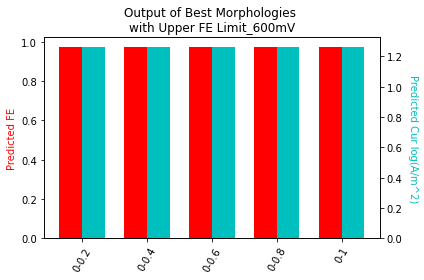

p = 30.9138 µm, l = 1.0844 µm, d = 9.994 µm, FE = 0.9677, Cur = 1.7396

END: 170


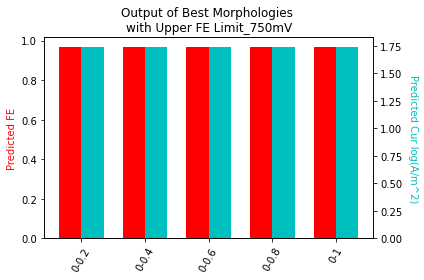

p = 30.8521 µm, l = 1.0128 µm, d = 9.9795 µm, FE = 0.8966, Cur = 1.7808

END: 170


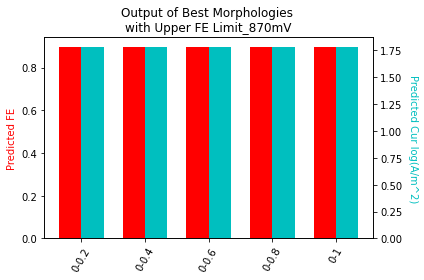

In [6]:
#labels = ['0-1', '0.20-1', '0.40-1', '0.60-1', '0.80-1']
labels = ['0-0.2', '0-0.4', '0-0.6', '0-0.8', '0-1']
pots = ['600mV', '750mV', '870mV']
for pot in pots:
    difs = ['170']
    for dif in difs:
        with open('./Wire/Mar15/' + pot + '/' + dif + '/BO_results_ceiling_' + dif + '.pkl', 'rb') as f:
            results = pickle.load(f)
        for i, dic in enumerate(results):
            for key, value in dic.items():
                dic[key] = round(value, 4)
                s = 'p = ' + str(dic.get('p')) + ' µm, l = ' + str(dic.get('l')) + ' µm, '\
                    + 'd = ' + str(dic.get('d')) + ' µm, FE = ' + str(dic.get('FE')) + ', Cur = ' + str(dic.get('Cur')) + '\n'
            print(s)
        print("END: " + str(dif))
        fes = []
        curs = []
        for dic in results:
            fes.append(dic.get('FE'))
            curs.append(dic.get('Cur'))
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.bar(labels, fes, width=-0.35, align='edge', color='r') #yerr=fes_std
        ax2.bar(labels, curs, width=0.35, align='edge', color='c') #yerr=curs_std
        ax1.set_xticklabels(labels, rotation=60)
        ax1.set_ylabel('Predicted FE', color='r')
        ax2.set_ylabel('Predicted Cur log(A/m^2)', color='c', rotation=270, labelpad=15)
        ax1.set_title('Output of Best Morphologies \nwith Upper FE Limit_' + pot)
        plt.tight_layout()
        plt.savefig('./Wire/Mar15/Result_Graphs/' + str(dif) + '/' + str(pot) + 'Upper_morphs.png', dpi=200)
        plt.show()

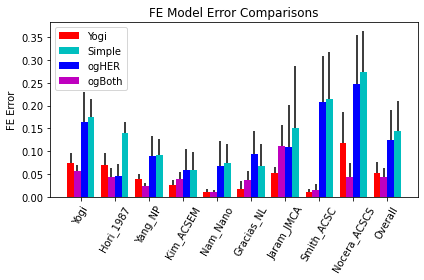

In [10]:
errors = pd.read_csv('Models_Errors_Dec20.csv')
yogis = errors[errors['Model'] == 'Yogi']
Simple = errors[errors['Model'] == 'Simple']
ogHER = errors[errors['Model'] == 'ogHER']
ogBoth = errors[errors['Model'] == 'ogHERandCER']
xes = [0,1,2,3,4,5,6,7,8,9]

plt.bar([x-0.3 for x in xes], yogis['Avg FE'], yerr=[np.zeros(len(yogis['Std FE'])), yogis['Std FE']], width=0.2, align='center', color='r', label='Yogi')
plt.bar([x+0.3 for x in xes], Simple['Avg FE'], yerr=[np.zeros(len(Simple['Std FE'])), Simple['Std FE']], width=0.2, align='center', color='c', label='Simple')
plt.bar([x+0.1 for x in xes], ogHER['Avg FE'], yerr=[np.zeros(len(ogHER['Std FE'])), ogHER['Std FE']], width=0.2, align='center', color='b', label='ogHER')
plt.bar([x-0.1 for x in xes], ogBoth['Avg FE'], yerr=[np.zeros(len(ogBoth['Std FE'])), ogBoth['Std FE']], width=0.2, align='center', color='m', label='ogBoth')
plt.xticks(ticks=xes, labels=yogis['Source'], rotation=60)
plt.title('FE Model Error Comparisons')
plt.legend(loc='upper left')
plt.ylabel('FE Error')
plt.tight_layout()
plt.savefig('All_Models_FE_Comp.png', dpi=200)
plt.show()